In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
import os
import logging
import germline_cnv_evaluation as cnv_eval

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s',
                    datefmt='%m-%d %H:%M')


In [1]:
truth_var_only_call_set_pkl = '/Volumes/dsde_working/mehrtash/gCNV_theano_eval_new/GPC2-WES/gs/\
gpc2_gs_callset_v3__CNV_eval_suite_ver__0.1__.pkl'

# load pickled results
truth_call_set_dict, truth_included_loci = cnv_eval.GenericCNVCallSet.from_pickle(truth_var_only_call_set_pkl)

# for GS calls: no need to pad segments before merging (by design, the best segment for each sample
# is already there)
truth_merge_padding = 0

# for GS calls: choose the highest quality segment from the overlapping set (it is reasonable
# to assume that the highest quality segment for each sample is the right call for that sample)
truth_merge_interval_consensus_strategy = 'highest_quality'

# for GS calls: the intervals end-points are the same as the highest quality segment
truth_merge_call_consensus_strategy = 'highest_quality'

# merge overlapping segments
truth_merged_call_set_dict = dict()
for sample_name in truth_call_set_dict.keys():
    truth_merged_call_set_dict[sample_name] = truth_call_set_dict[sample_name].merge_overlapping_variants(
        truth_merge_padding,
        interval_consensus_strategy=truth_merge_interval_consensus_strategy,
        call_consensus_strategy=truth_merge_call_consensus_strategy)

In [23]:
# load pickled variant-only trial call-sets
trial_call_set_dicts = list()
trial_included_loci_list = list()

gcnv_var_only_call_set_pkl = '/Volumes/dsde_working/mehrtash/gCNV_theano_eval_new/GPC2-WES/output/\
GPC2-WES-eval_0005_cc87f20b/VCFs/GPC2-WES_gCNV_segments_callset__CNV_eval_suite_ver__0.1__.pkl'
gcnv_call_set_dict, gcnv_included_loci = cnv_eval.GenericCNVCallSet.from_pickle(gcnv_var_only_call_set_pkl)
trial_call_set_dicts.append(gcnv_call_set_dict)
trial_included_loci_list.append(gcnv_included_loci)

codex_var_only_call_set_pkl = '/Volumes/dsde_working/mehrtash/gCNV_theano_eval_new/GPC2-WES/other_tools/CODEX/\
GPC2-WES_CODEX_segments_callset__CNV_eval_suite_ver__0.1__.pkl'
codex_call_set_dict, codex_included_loci = cnv_eval.GenericCNVCallSet.from_pickle(codex_var_only_call_set_pkl)
trial_call_set_dicts.append(codex_call_set_dict)
trial_included_loci_list.append(codex_included_loci)

truth_sample_names = set(truth_call_set_dict.keys())
mutual_samples = truth_sample_names
for trial_call_set_dict in trial_call_set_dicts:
    mutual_samples = mutual_samples.intersection(trial_call_set_dict.keys())
mutual_samples = list(mutual_samples)

# find the raw evaluation summaries for each trial call-set
raw_evaluation_summary_dicts = list()
for csi in range(len(trial_call_set_dicts)):
    raw_evaluation_summary_dict = dict()
    raw_evaluation_summary_dicts.append(raw_evaluation_summary_dict)
    for sample_name in mutual_samples:        
        evaluator = cnv_eval.CNVTrialCallSetEvaluator(
            truth_merged_call_set_dict[sample_name],
            trial_call_set_dicts[csi][sample_name],
            truth_included_loci=trial_included_loci_list[csi], ## NOTE
            trial_included_loci=trial_included_loci_list[csi],
            min_overlap_fraction_for_variant_matching=0.75,
            truth_overlapping_set_selection_strategy="largest_overlap")
        raw_evaluation_summary_dict[sample_name] = evaluator()

(0, 1)

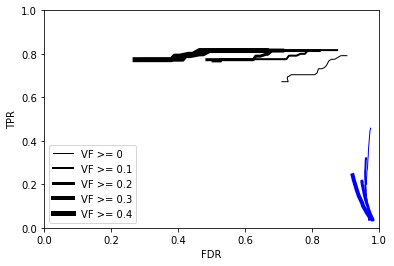

In [57]:
def get_cumulutative_statistics_with_filter(raw_evaluation_summary_dict,
                                            truth_filter, trial_filter,
                                            excluded_samples={}):
    true_positives_sum = 0
    false_positives_sum = 0
    false_negatives_sum = 0
    
    for sample_name in mutual_samples:
        if sample_name in excluded_samples:
            continue
        raw_evaluation_summary = raw_evaluation_summary_dict[sample_name]
        filtered_evaluation_summary = raw_evaluation_summary.get_filtered_summary(truth_filter, trial_filter)
        true_positives_sum += filtered_evaluation_summary.true_positive_count
        false_positives_sum += filtered_evaluation_summary.false_positive_count
        false_negatives_sum += filtered_evaluation_summary.false_negative_count
    
    return true_positives_sum, false_positives_sum, false_negatives_sum

trial_min_quality_lists = [
    np.arange(0, 300, 10), # gcnv
    np.arange(0, 99, 5) # codex
]

trial_plot_colors = ['black', 'blue']
min_variant_frequency_list = [0, 0.1, 0.2, 0.3, 0.4]
line_width_list = [1, 2, 3, 4, 5]

min_length = 5000
truth_min_quality = 500

for min_variant_frequency, line_width in zip(min_variant_frequency_list, line_width_list):
    for idx, (raw_evaluation_summary_dict, trial_min_quality_list, trial_plot_color) in enumerate(zip(
        raw_evaluation_summary_dicts, trial_min_quality_lists, trial_plot_colors)):

        TPR_list = []
        FDR_list = []

        for trial_min_quality in trial_min_quality_list:

            truth_filter = cnv_eval.GenericCopyNumberVariant.get_variant_filter(
                min_variant_frequency=min_variant_frequency,
                min_length=min_length,
                min_quality=truth_min_quality)

            trial_filter = cnv_eval.GenericCopyNumberVariant.get_variant_filter(
                min_quality=trial_min_quality,
                min_variant_frequency=min_variant_frequency,
                min_length=min_length)

            (true_positives_sum, false_positives_sum, false_negatives_sum) = get_cumulutative_statistics_with_filter(
                raw_evaluation_summary_dict,
                truth_filter, trial_filter,
                {})

            truth_truth_positives = true_positives_sum + false_negatives_sum
            total_trial_positives = true_positives_sum + false_positives_sum

            if truth_truth_positives > 0:
                TPR = true_positives_sum / truth_truth_positives
            else:
                TPR = np.nan 

            if total_trial_positives > 0:
                FDR = false_positives_sum / total_trial_positives
            else:
                FPR = np.nan

            TPR_list.append(TPR)
            FDR_list.append(FDR)

        plt.plot(FDR_list, TPR_list,
                 color=trial_plot_color,
                 lw=line_width,
                 label='VF >= {0}'.format(min_variant_frequency) if idx == 0 else None)

plt.xlabel('FDR')
plt.ylabel('TPR')
plt.legend(loc='lower left')
plt.ylim((0, 1))
plt.xlim((0, 1))

In [ ]:
def plot_evaluation_summary_dict(evaluation_summary_dict):
    sample_true_positive_list = []
    sample_false_negative_list = []
    sample_false_positive_list = []
    
    sample_names = list(evaluation_summary_dict.keys())
    for si, sample_name in enumerate(sample_names):
        sample_true_positive_list.append(evaluation_summary_dict[sample_name].true_positive_count)
        sample_false_negative_list.append(evaluation_summary_dict[sample_name].false_negative_count)
        sample_false_positive_list.append(evaluation_summary_dict[sample_name].false_positive_count)

    fig = plt.figure(figsize=(16,4))
    ax = plt.gca()

    def get_outliers_ztest(metric, z_threshold=2.0, side='above'):
        metric = np.asarray(metric)
        mean = np.mean(metric)
        std = np.std(metric)
        metric_z = (metric - mean) / std
        if side == 'above':
            return [si for si, z in enumerate(metric_z) if z >= z_threshold]
        else:
            return [si for si, z in enumerate(metric_z) if z <= -z_threshold]

    si_too_many_fn = get_outliers_ztest(sample_false_negative_list, side='above')
    si_too_many_fp = get_outliers_ztest(sample_false_positive_list, side='above')
    si_too_few_tp = get_outliers_ztest(sample_true_positive_list, side='below')

    print('samples with too many false positives: {0}'.format([sample_names[si] for si in si_too_many_fp]))
    print('samples with too many false negatives: {0}'.format([sample_names[si] for si in si_too_many_fn]))
    print('samples with too few true positives: {0}'.format([sample_names[si] for si in si_too_few_tp]))

    ax.plot(sample_true_positive_list, lw=0, marker='.', markersize=2, color='green', label='TP')
    ax.plot(sample_false_negative_list, lw=0, marker='.', markersize=2, color='blue', label='FN')
    ax.plot(sample_false_positive_list, lw=0, marker='.', markersize=2, color='red', label='FP')

    x_labels = sorted(list(set(si_too_many_fn).union(set(si_too_many_fp)).union(set(si_too_few_tp))))

    for si in si_too_few_tp:
        ax.plot([si], [sample_true_positive_list[si]], lw=0, marker='.', markersize=8, color='green')

    for si in si_too_many_fn:
        ax.plot([si], [sample_false_negative_list[si]], lw=0, marker='.', markersize=8, color='blue')

    for si in si_too_many_fp:
        ax.plot([si], [sample_false_positive_list[si]], lw=0, marker='.', markersize=8, color='red')

    _ = ax.set_xticks(x_labels)
    _ = ax.set_xticklabels([sample_names[si] for si in x_labels], rotation=80)

    ax.set_ylabel('hits')
    ax.set_xlim((0, len(sample_names)-1))
    ax.legend()
    ax.set_yscale('log')

    excluded_samples = [sample_names[si] for si in x_labels]

samples with too many false positives: ['04C28102', '11C125675']
samples with too many false negatives: ['01C09263', '03C15023']
samples with too few true positives: []


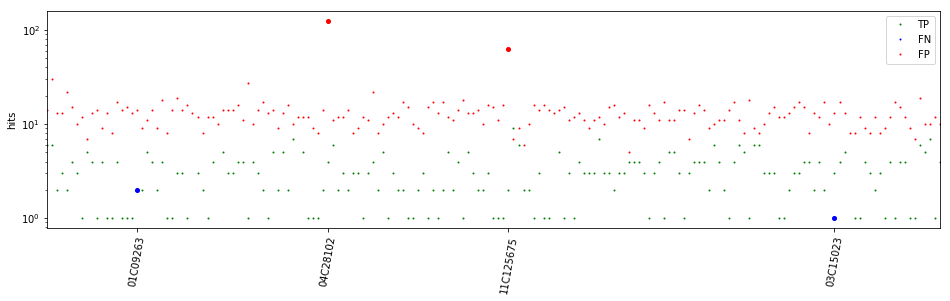

In [53]:
# gCNV
plot_evaluation_summary_dict(raw_evaluation_summary_dicts[0])

samples with too many false positives: ['04C28102', '11C125675']
samples with too many false negatives: ['01C09263', '01C07493', '04C24799', '10C111672', '03C15023']
samples with too few true positives: ['10C112784', '04C33040', '03C17952', '11C120612', '10C107606']


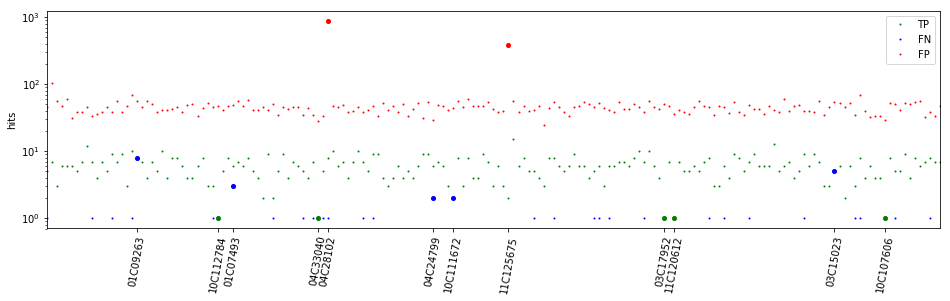

In [54]:
# CODEX
plot_evaluation_summary_dict(raw_evaluation_summary_dicts[1])